In [1]:
import numpy as np
from dotenv import load_dotenv
from dwave.system import DWaveSampler, EmbeddingComposite
from numpy import hamming
from openjij import SQASampler
import openjij
from pyqubo import Array, Constraint, LogEncInteger, solve_qubo
import math
import os
import dimod
from minorminer import find_embedding
from dwave.system import FixedEmbeddingComposite
from dwave.embedding import embed_bqm
from dwave.embedding import MinimizeEnergy
from matplotlib import pyplot as plt
import sklearn
import itertools
from copy import copy, deepcopy
import pandas as pd
from load_dataset import load_knapsack

In [62]:
load_dotenv()

TOKEN = os.getenv("TOKEN")
endpoint = "https://cloud.dwavesys.com/sapi/"
solver = "QA"
num_reads = 10

In [2]:
dataset = load_knapsack("../dataset/knapsack/knap_custom.csv")[6]
W = dataset.capacity
N = dataset.n
cost_list = dataset.cost_list
weight_list = dataset.weight_list
opt = dataset.optimum_state
print("opt:", dataset.optimum_value)


opt: 1458


In [64]:
x = Array.create('x', shape=(N), vartype='BINARY')
y = LogEncInteger("y", (0, W))

In [65]:
# key1 = max(cost_list, key=lambda k: cost_list[k])
max_c = max(cost_list)
B = 1
A = B * max_c * 2

In [66]:
HA = Constraint(
    A * (W - sum(weight_list[a] * x[a] for a in range(N)) - y)**2, label='HA'
)

HB = - B * sum(cost_list[a] * x[a] for a in range(N))

In [67]:
H = HA + HB
model = H.compile()
Q, offset = model.to_qubo()

In [68]:
if solver == "QA":
    dw_sampler = DWaveSampler(solver='Advantage_system6.1',
                            token=TOKEN, endpoint=endpoint)
    adj = {}
    for k in Q.keys():
        adj[k] = 1
    embedding = find_embedding(adj, dw_sampler.edgelist)
    # bqm_embed = embed_bqm(bqm, embedding, dw_sampler.adjacency)
    sampler = FixedEmbeddingComposite(dw_sampler, embedding)
    # sampler = EmbeddingComposite(dw_sampler)
    # sampleset_embed = dw_sampler.sample(bqm_embed, num_reads=10)
    print("setting DW sampler")
else:
    sampler = SQASampler(num_reads=num_reads)
    print("setting SQA sampler")

setting DW sampler


In [69]:
# t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
# s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
t = [(0, 20)]
s = [(0, 1)]

schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(schedules)


[[(0, 0), (20, 1)]]


In [70]:
def plot_schedules(t, s, save_path="output.jpg", title=None):
    linestyle = ["solid", "dotted", "dashed",
                 "dashdot", (0, (1, 10)), (0, (3, 1, 1, 1))]
    if len(t) == 1:
        fig, ax = plt.subplots(1)
        fig = [fig]
        ax = [ax]
    else:
        fig, ax = plt.subplots(1, len(t))
        fig.set_figwidth(5 * len(t))

    for i in range(len(t)):
        ax[i].plot(t[i], s[i])
        ax[i].set_xlim(-1.0, t[i][-1] + 1.0)
        ax[i].set_ylim(-0.1, 1.1)
        if not title == None:
            ax[i].set_title(title[i].upper())

    plt.tight_layout()
    plt.savefig(save_path)

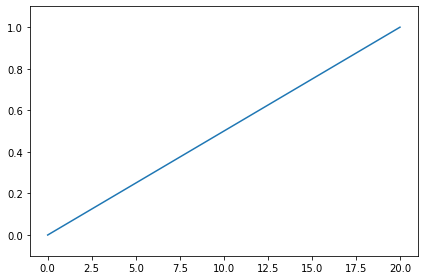

In [71]:
plot_schedules(t, s, "anneal_schedule.jpg")

In [72]:
samplesets = []
for schedule in schedules:
    print("annealing start")
    if solver == "QA":
        samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule))
    else:
        samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")

annealing start
annealing end


In [73]:
def dict_from_sampleview(sampleview):
    d = {}

    for key in sampleview.keys():
        d[key] = sampleview.get(key)
    
    return d

In [74]:
def transform_sample(sampleset, schedule, model):
    # decoded_samples = model.decode_sampleset(
    #     sampleset=sampleset, vartype="BINARY")
    decoded_samples = []
    for sample, record in zip(sampleset, sampleset.record):
        decoded_sample = model.decode_sample(
            dict_from_sampleview(sample), vartype="BINARY")
        decoded_samples.append((decoded_sample, record[1]))

    value_set = []
    for decoded_sample, energy in decoded_samples:
        cost = 0
        weight = 0
        for k in range(N):
            if decoded_sample.array('x', k) != 0:
                cost += cost_list[k]
                weight += weight_list[k]

        sol_y = sum(2**k * v for k, v in [(elem, decoded_sample.array('y', elem))
                                          for elem in range(math.ceil(math.log2(W)))])

        value_set.append(
            {"cost": cost, "weight": weight, "energy": energy, "sol_y": sol_y, "broken": decoded_sample.constraints(only_broken=True)})

    value_df = pd.DataFrame(value_set)
    value_df_sorted_cost = value_df[value_df["weight"] <= W].sort_values(by=[
        "cost"])
    value_max = value_df_sorted_cost.loc[value_df_sorted_cost["cost"].idxmax()]
    value_min = value_df_sorted_cost.loc[value_df_sorted_cost["cost"].idxmin()]
    value_ave = value_df_sorted_cost["cost"].mean()

    # value_df_sorted_by_energy = value_df.sort_values(by=["energy"])

    return {"anneal_time": sampleset.info["timing"]["qpu_anneal_time_per_sample"], "anneal_schedule": schedule, "info_sets": value_set, "best_value": value_max, "average_cost": value_ave, "worst_value": value_min, "dataframe": value_df}


def v_transform_sample(samplesets, schedules, model):
    if type(samplesets) == list:
        sample_info = []
        for (sampleset, schedule) in zip(samplesets, schedules):
            sample_info.append(transform_sample(sampleset, schedule, model))
        return sample_info
    else:
        return transform_sample(transform_sample(samplesets, schedules, model))


In [75]:
def output_sample_info(sample_info):
    print("anneal time = {}".format(sample_info["anneal_time"]))
    print("anneal schedule = {}".format(sample_info["anneal_schedule"]))
    print("----- best ------")
    print("slack_Y = {}".format(sample_info["best_value"]["sol_y"]))
    print("broken: {}".format(sample_info["best_value"]["broken"]))
    print("cost : " + str(sample_info["best_value"]["cost"]))
    print("weight : " + str(sample_info["best_value"]["weight"]))
    print("-----------------")
    print("---- average -----")
    print("cost : " + str(sample_info["average_cost"]))
    print("-----------------")
    print("----- worst -----")
    print("slack_Y = {}".format(sample_info["worst_value"]["sol_y"]))
    print("broken: {}".format(sample_info["worst_value"]["broken"]))
    print("cost : " + str(sample_info["worst_value"]["cost"]))
    print("weight : " + str(sample_info["worst_value"]["weight"]))
    print("-----------------")
    print("-----describe----")
    print(sample_info["dataframe"].describe())
    print()


def v_output_sample_info(samples_info):
    if type(samples_info) == list:
        for sample_info in samples_info:
            output_sample_info(sample_info)
    else:
        output_sample_info(samples_info)


In [76]:
sample_info = v_transform_sample(samplesets, schedules, model)
v_output_sample_info(sample_info)


anneal time = 20.0
anneal schedule = [(0, 0), (20, 1)]
----- best ------
slack_Y = 149
broken: {'HA': (False, 173280.0)}
cost : 1184
weight : 620
-----------------
---- average -----
cost : 947.1
-----------------
----- worst -----
slack_Y = 549
broken: {'HA': (False, 5495520.0)}
cost : 712
weight : 367
-----------------
-----describe----
            cost      weight        energy       sol_y
count    10.0000   10.000000  1.000000e+01   10.000000
mean    947.1000  491.500000 -2.678593e+08  490.300000
std     160.4199   85.293285  2.194574e+06  130.773808
min     712.0000  367.000000 -2.698780e+08  149.000000
25%     851.0000  440.000000 -2.696106e+08  524.500000
50%     861.0000  446.500000 -2.688005e+08  546.500000
75%    1065.0000  553.000000 -2.664642e+08  552.000000
max    1184.0000  620.000000 -2.642983e+08  567.000000



## リバースアニーリング

### 最良値採用

In [77]:
init = samplesets[0].samples()[0]

In [78]:
t = [(0, 5, 15, 20)]
s = [(1, 0.2, 0.2, 1.0)]

reverse_schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(reverse_schedules)

[[(0, 1), (5, 0.2), (15, 0.2), (20, 1.0)]]


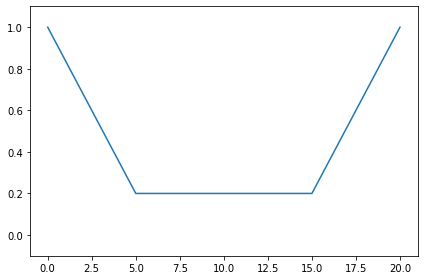

In [79]:
plt.close()
plot_schedules(t, s, "reverse_anneal.jpg")


In [80]:
reverse_samplesets = []
for schedule in reverse_schedules:
    print("annealing start")
    if solver == "QA":
        reverse_samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule, initial_state=init, reinitialize_state=False))
    else:
        reverse_samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")


annealing start
annealing end


In [81]:
reverse_sample_info = v_transform_sample(reverse_samplesets, reverse_schedules, model)
v_output_sample_info(reverse_sample_info)


anneal time = 20.0
anneal schedule = [(0, 1), (5, 0.2), (15, 0.2), (20, 1.0)]
----- best ------
slack_Y = 565
broken: {'HA': (False, 10944480.0)}
cost : 1170
weight : 609
-----------------
---- average -----
cost : 986.1
-----------------
----- worst -----
slack_Y = 524
broken: {'HA': (False, 4062720.0)}
cost : 774
weight : 407
-----------------
-----describe----
              cost      weight        energy       sol_y
count    10.000000   10.000000  1.000000e+01   10.000000
mean    986.100000  513.500000 -2.656420e+08  550.200000
std     140.151069   71.012127  7.214202e+06   34.746063
min     774.000000  407.000000 -2.699318e+08  520.000000
25%     861.750000  446.750000 -2.695754e+08  524.250000
50%    1018.500000  531.000000 -2.690071e+08  546.000000
75%    1065.000000  553.000000 -2.662237e+08  560.750000
max    1170.000000  609.000000 -2.473984e+08  636.000000



### 最悪値採用

In [82]:
init = samplesets[0].samples()[-1]


In [83]:
t = [(0, 5, 15, 20)]
s = [(1, 0.2, 0.2, 1.0)]

reverse_worst_schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(reverse_worst_schedules)


[[(0, 1), (5, 0.2), (15, 0.2), (20, 1.0)]]


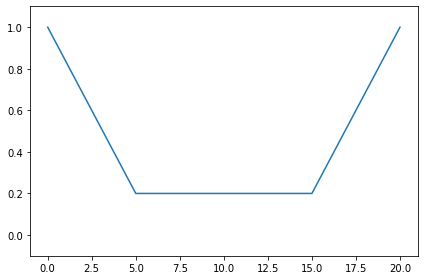

In [84]:
plt.close()
plot_schedules(t, s, "reverse_anneal.jpg")


In [85]:
reverse_worst_samplesets = []
for schedule in reverse_worst_schedules:
    print("annealing start")
    if solver == "QA":
        reverse_worst_samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule, initial_state=init, reinitialize_state=False))
    else:
        reverse_worst_samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")


annealing start
annealing end


In [ ]:
reverse_worst_sample_info = v_transform_sample(
    reverse_worst_samplesets, reverse_worst_schedules, model)
v_output_sample_info(reverse_worst_samplesets)


In [161]:
for info in sample_info:
    print(info["best_value"]["cost"], "&",
          info["average_cost"], "&", info["worst_value"]["cost"], "\\\\")
for info in reverse_sample_info:
    print(info["best_value"]["cost"], "&",
          info["average_cost"], "&", info["worst_value"]["cost"], "\\\\")


1440 & 1029.7119592875317 & 285 \\
1441 & 1018.005171543895 & 221 \\
1441 & 1011.6242495585639 & 184 \\
1448 & 1019.7054924242424 & 184 \\
1442 & 1019.0351390922401 & 312 \\
1441 & 1050.4261026826082 & 289 \\
1436 & 1050.4963261197786 & 299 \\


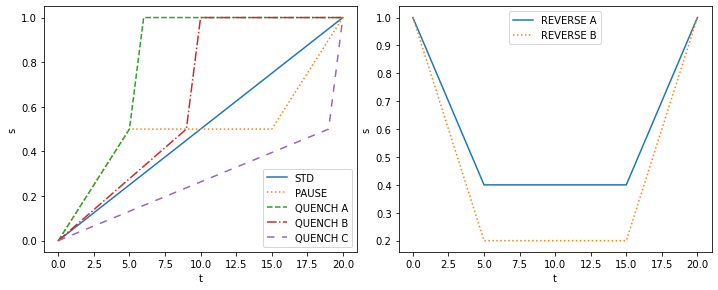

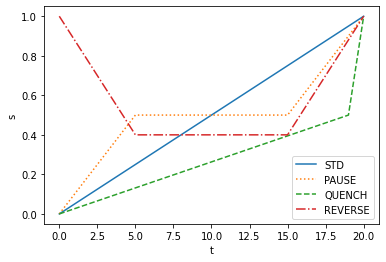

In [162]:
t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
t2 = [(0, 5, 15, 20), (0, 5, 15, 20)]
s2 = [(1.0, 0.4, 0.4, 1.0), (1, 0.2, 0.2, 1.0)]
t_set = [t, t2]
s_set = [s, s2]
label = [["STD", "PAUSE", "QUENCH A", "QUENCH B",
          "QUENCH C"], ["REVERSE A", "REVERSE B"]]
linestyle = ["solid", "dotted", "dashed",
             "dashdot",  (0, (5, 5)), (0, (3, 1, 1, 1))]

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.tight_layout()

for i in range(2):
    for j in range(len(t_set[i])):
        ax[i].plot(t_set[i][j], s_set[i][j], label=label[i]
                   [j], linestyle=linestyle[j])

        ax[i].set_xlabel("t")
        ax[i].set_ylabel("s")
        ax[i].legend(loc=0)
plt.savefig("fixed-anneal_schedule.jpg")


t = [(0, 20), (0, 5, 15, 20), (0, 19, 20), (0, 5, 15, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1),  (0, 0.5, 1), (1.0, 0.4, 0.4, 1.0)]
label = ["STD", "PAUSE", "QUENCH", "REVERSE"]
fig, ax = plt.subplots()

for i in range(len(t)):
    ax.plot(t[i], s[i], label=label[i], linestyle=linestyle[i])
    ax.set_xlabel("t")
    ax.set_ylabel("s")
    ax.legend(loc=0)

plt.savefig("fixed-example_schedules.jpg")


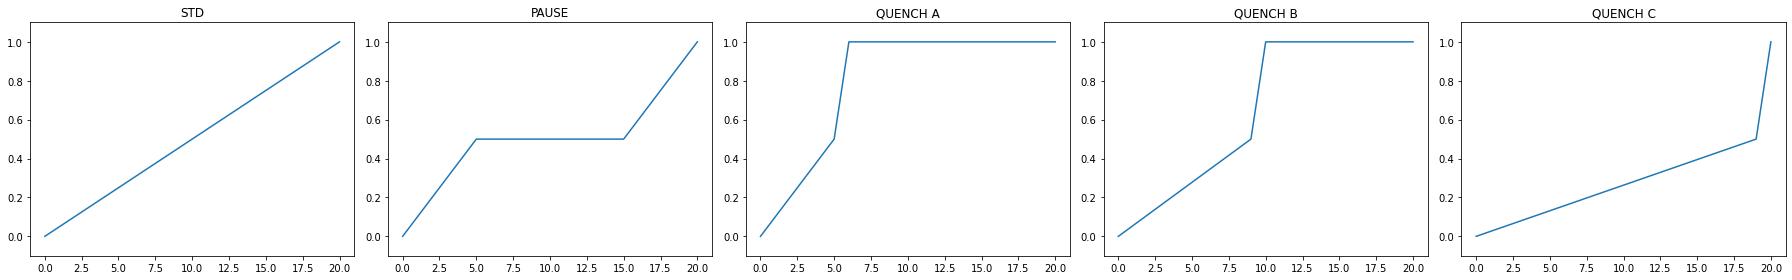

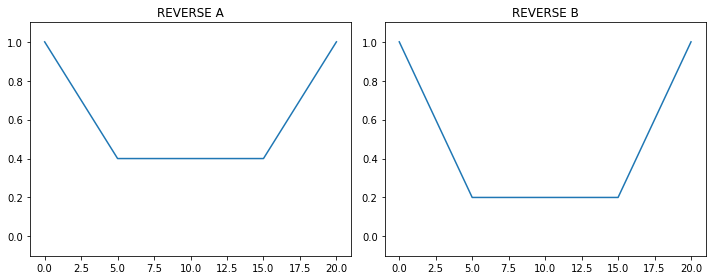

In [163]:
t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
plot_schedules(t, s, "pause_quench_schedule.jpg", [
               "std", "pause", "quench A", "quench B", "quench C"])

t = [(0, 5, 15, 20), (0, 5, 15, 20)]
s = [(1.0, 0.4, 0.4, 1.0), (1, 0.2, 0.2, 1.0)]
plot_schedules(t, s, "reverse_anneal.jpg", [
               "reverse A", "reverse B"])
